In [104]:
import xarray as xr
import matplotlib.pyplot as plt

In [58]:
ds = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube_small.zarr/').sel(lat=slice(55, 45), lon=slice(15, 25), time=slice('2004', '2006')).t2m.load()
ds

<xarray.DataArray 't2m' (hour: 24, time: 1096, lat: 101, lon: 101)>
array([[[[274.0659 , 274.0659 ,       nan, ..., 271.84116, 271.8296 ,
          271.8315 ],
         [      nan,       nan,       nan, ..., 271.87006, 271.8585 ,
          271.8604 ],
         [      nan,       nan,       nan, ..., 271.8604 , 271.8585 ,
          271.86234],
         ...,
         [271.97983, 272.63858, 273.6036 , ..., 274.5128 , 274.52048,
          274.66495],
         [273.06042, 272.89862, 273.23187, ..., 275.26205, 275.40268,
          275.47202],
         [273.76926, 273.1625 , 273.28772, ..., 275.2428 , 275.2948 ,
          275.20428]],

        [[274.16605, 274.16605,       nan, ..., 269.24463, 269.18494,
          269.12137],
         [      nan,       nan,       nan, ..., 269.29858, 269.2273 ,
          269.15604],
         [      nan,       nan,       nan, ..., 269.31012, 269.24658,
          269.18494],
...
         [275.05017, 275.07715, 275.18695, ..., 268.5416 , 268.61478,
          268.58203],
         [275.76096, 275.41617, 275.1985 , ..., 269.27737, 269.47772,
          269.33902],
         [276.07877, 275.53558, 275.3102 , ..., 268.81894, 268.43372,
          268.5127 ]],

        [[280.66696, 280.66696,       nan, ..., 277.95102, 277.8836 ,
          277.7892 ],
         [      nan,       nan,       nan, ..., 277.9491 , 277.86435,
          277.7642 ],
         [      nan,       nan,       nan, ..., 277.90866, 277.85858,
          277.78152],
         ...,
         [278.67526, 279.10483, 279.57288, ..., 270.3965 , 270.6026 ,
          271.14578],
         [279.07593, 279.17993, 279.54013, ..., 271.3076 , 271.42896,
          271.46555],
         [279.37448, 279.04318, 279.13757, ..., 270.8973 , 270.81448,
          271.32108]]]], dtype=float32)
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
  * lat      (lat) float32 55.0 54.9 54.8 54.7 54.6 ... 45.4 45.3 45.2 45.1 45.0
  * lon      (lon) float32 15.0 15.1 15.2 15.3 15.4 ... 24.6 24.7 24.8 24.9 25.0
  * time     (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2006-12-31
Attributes:
    long_name:  2 metre temperature
    units:      K

In [59]:
import numpy as np

def calculate_anomaly(x: xr.DataArray, msc_only: bool = False) -> tuple[xr.DataArray, xr.DataArray | None]:
    gb = x.groupby('time.dayofyear')
    msc = gb.mean('time').compute()

    msc_0 = msc.copy().assign_coords(dayofyear=np.arange(1 - 366, 1))
    msc_1 = msc.copy().assign_coords(dayofyear=np.arange(367, 367 + 366))
    msc_stack = xr.concat((msc_0, msc, msc_1), dim='dayofyear')
    msc_smooth = msc_stack.rolling(dayofyear=17, min_periods=5, center=True).mean().sel(dayofyear=slice(1, 366))

    if msc_only:
        anomalies = None
    else:
        anomalies = gb - msc_smooth
        anomalies = anomalies.drop('dayofyear')

    return msc_smooth, anomalies

In [76]:
msc, _ = calculate_anomaly(ds, msc_only=True)

In [82]:
m = msc.stack(time=['dayofyear', 'hour']).reset_index('time')

In [83]:
m

<xarray.DataArray 't2m' (lat: 101, lon: 101, time: 8784)>
array([[[276.3001 , 276.27182, 276.22427, ..., 276.43924, 276.31665,
         276.36392],
        [276.3001 , 276.27182, 276.22427, ..., 276.43924, 276.31665,
         276.36392],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [271.1246 , 271.0442 , 270.99237, ..., 271.6131 , 271.4917 ,
         271.34998],
        [271.0337 , 270.94025, 270.8777 , ..., 271.51532, 271.4107 ,
         271.2649 ],
        [271.0068 , 270.91562, 270.85278, ..., 271.46112, 271.36548,
         271.23532]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [271.804  , 271.79855, 271.73523, ..., 272.135  , 271.91214,
         271.8286 ],
        [271.62048, 271.5712 , 271.5305 , ..., 271.91412, 271.71997,
         271.61993],
        [271.51196, 271.45865, 271.40402, ..., 271.75027, 271.5424 ,
         271.4713 ]],

       [[272.3159 , 272.13336, 272.04645, ..., 272.77167, 272.5915 ,
         272.45016],
        [271.71985, 271.5304 , 271.45477, ..., 272.20154, 272.0286 ,
         271.9182 ],
        [271.7503 , 271.6084 , 271.5411 , ..., 272.21164, 272.08865,
         271.96002],
        ...,
        [271.47513, 271.51376, 271.45245, ..., 271.7516 , 271.52252,
         271.40802],
        [271.2732 , 271.29272, 271.2526 , ..., 271.552  , 271.3347 ,
         271.21268],
        [271.17258, 271.10654, 271.0845 , ..., 271.4132 , 271.21887,
         271.12634]]], dtype=float32)
Coordinates:
  * lat        (lat) float32 55.0 54.9 54.8 54.7 54.6 ... 45.3 45.2 45.1 45.0
  * lon        (lon) float32 15.0 15.1 15.2 15.3 15.4 ... 24.7 24.8 24.9 25.0
    dayofyear  (time) int64 1 1 1 1 1 1 1 1 ... 366 366 366 366 366 366 366 366
    hour       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: time
Attributes:
    long_name:  2 metre temperature
    units:      K

<xarray.DataArray 't2m' (lat: 101, lon: 101, time_: 8784)>
array([[[274.0659 , 273.99655, 273.97153, ..., 278.1186 , 276.53528,
         277.28842],
        [274.0659 , 273.99655, 273.97153, ..., 278.1186 , 276.53528,
         277.28842],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [271.84116, 271.73712, 271.5792 , ..., 275.61264, 275.32755,
         274.78436],
        [271.8296 , 271.71786, 271.55606, ..., 275.38342, 275.24088,
         274.69385],
        [271.8315 , 271.71402, 271.54645, ..., 275.1908 , 275.10605,
         274.63412]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [275.26205, 275.17538, 275.14648, ..., 272.27646, 271.95093,
         271.76602],
        [275.40268, 275.33527, 275.29868, ..., 270.83762, 270.52942,
         270.43887],
        [275.47202, 275.40652, 275.3603 , ..., 270.62766, 270.31946,
         270.28287]],

       [[273.76926, 273.124  , 273.0161 , ..., 271.73907, 271.61194,
         271.67358],
        [273.1625 , 272.69446, 272.58658, ..., 271.50406, 271.2633 ,
         271.26135],
        [273.28772, 272.75803, 272.62897, ..., 271.22284, 271.07068,
         271.12076],
        ...,
        [275.2428 , 275.11374, 275.0598 , ..., 271.27676, 270.9397 ,
         270.801  ],
        [275.2948 , 275.18695, 275.12915, ..., 271.06683, 270.72205,
         270.59106],
        [275.20428, 275.09448, 275.03284, ..., 270.83374, 270.4851 ,
         270.37146]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 55.0 54.9 54.8 54.7 54.6 ... 45.4 45.3 45.2 45.1 45.0
  * lon      (lon) float32 15.0 15.1 15.2 15.3 15.4 ... 24.6 24.7 24.8 24.9 25.0
    time     (time_) datetime64[ns] 2004-01-01 2004-01-01 ... 2004-12-31
    hour     (time_) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: time_
Attributes:
    long_name:  2 metre temperature
    units:      K

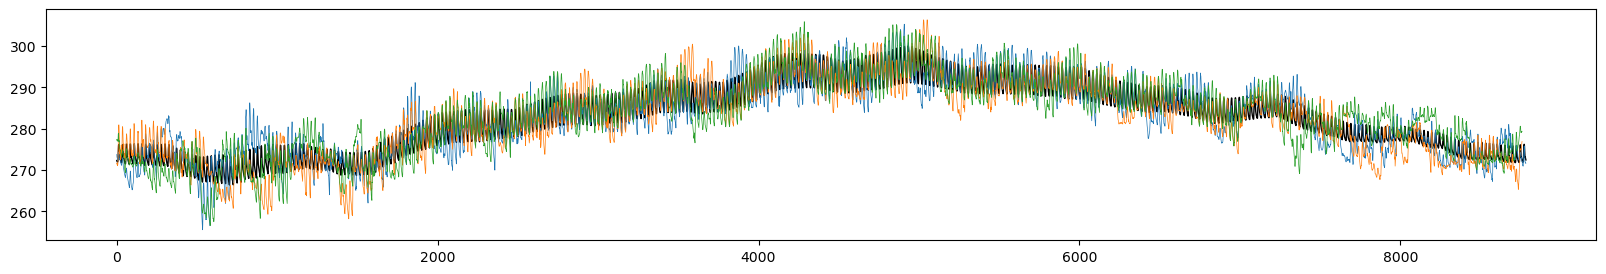

In [127]:
plt.figure(figsize=(20, 3))
plt.plot(msc.stack(time=['dayofyear', 'hour']).reset_index('time').sel(lat=40, lon=10, method='nearest'), lw=1., color='k')

for year in ['2004', '2005', '2006']:
    plt.plot(ds.sel(time=year).stack(time_=['time', 'hour']).sel(lat=40, lon=10, method='nearest').reset_index('time_').values.T, lw=0.5)



In [99]:
m

<xarray.DataArray 't2m' (lat: 101, lon: 101, time: 8784)>
array([[[276.3001 , 276.27182, 276.22427, ..., 276.43924, 276.31665,
         276.36392],
        [276.3001 , 276.27182, 276.22427, ..., 276.43924, 276.31665,
         276.36392],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [271.1246 , 271.0442 , 270.99237, ..., 271.6131 , 271.4917 ,
         271.34998],
        [271.0337 , 270.94025, 270.8777 , ..., 271.51532, 271.4107 ,
         271.2649 ],
        [271.0068 , 270.91562, 270.85278, ..., 271.46112, 271.36548,
         271.23532]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [271.804  , 271.79855, 271.73523, ..., 272.135  , 271.91214,
         271.8286 ],
        [271.62048, 271.5712 , 271.5305 , ..., 271.91412, 271.71997,
         271.61993],
        [271.51196, 271.45865, 271.40402, ..., 271.75027, 271.5424 ,
         271.4713 ]],

       [[272.3159 , 272.13336, 272.04645, ..., 272.77167, 272.5915 ,
         272.45016],
        [271.71985, 271.5304 , 271.45477, ..., 272.20154, 272.0286 ,
         271.9182 ],
        [271.7503 , 271.6084 , 271.5411 , ..., 272.21164, 272.08865,
         271.96002],
        ...,
        [271.47513, 271.51376, 271.45245, ..., 271.7516 , 271.52252,
         271.40802],
        [271.2732 , 271.29272, 271.2526 , ..., 271.552  , 271.3347 ,
         271.21268],
        [271.17258, 271.10654, 271.0845 , ..., 271.4132 , 271.21887,
         271.12634]]], dtype=float32)
Coordinates:
  * lat        (lat) float32 55.0 54.9 54.8 54.7 54.6 ... 45.3 45.2 45.1 45.0
  * lon        (lon) float32 15.0 15.1 15.2 15.3 15.4 ... 24.7 24.8 24.9 25.0
    dayofyear  (time) int64 1 1 1 1 1 1 1 1 ... 366 366 366 366 366 366 366 366
    hour       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: time
Attributes:
    long_name:  2 metre temperature
    units:      K

In [101]:
msc_e = msc.sel(dayofyear=ds.time.dt.dayofyear)
msc_e

<xarray.DataArray 't2m' (hour: 24, time: 1096, lat: 101, lon: 101)>
array([[[[276.3001 , 276.3001 ,       nan, ..., 271.1246 , 271.0337 ,
          271.0068 ],
         [      nan,       nan,       nan, ..., 271.09265, 271.0391 ,
          270.97537],
         [      nan,       nan,       nan, ..., 271.03085, 271.01917,
          270.97864],
         ...,
         [270.65823, 271.19952, 271.8124 , ..., 270.8204 , 270.89758,
          270.99918],
         [271.6067 , 271.39127, 271.63806, ..., 271.804  , 271.62048,
          271.51196],
         [272.3159 , 271.71985, 271.7503 , ..., 271.47513, 271.2732 ,
          271.17258]],

        [[276.10406, 276.10406,       nan, ..., 270.81503, 270.7254 ,
          270.69888],
         [      nan,       nan,       nan, ..., 270.79135, 270.7374 ,
          270.67227],
         [      nan,       nan,       nan, ..., 270.734  , 270.7236 ,
          270.68243],
...
         [270.79153, 271.24075, 271.79846, ..., 271.17944, 271.2048 ,
          271.25046],
         [271.73645, 271.5171 , 271.74252, ..., 271.98114, 271.71143,
          271.49188],
         [272.26254, 271.76126, 271.79214, ..., 271.61304, 271.36276,
          271.2352 ]],

        [[276.59604, 276.59604,       nan, ..., 271.55298, 271.462  ,
          271.4266 ],
         [      nan,       nan,       nan, ..., 271.5474 , 271.48376,
          271.41068],
         [      nan,       nan,       nan, ..., 271.50702, 271.47925,
          271.42746],
         ...,
         [270.83115, 271.3186 , 271.89285, ..., 270.96606, 271.0272 ,
          271.10043],
         [271.79358, 271.56946, 271.8248 , ..., 271.88486, 271.65894,
          271.4837 ],
         [272.40283, 271.84848, 271.87665, ..., 271.42673, 271.19742,
          271.0922 ]]]], dtype=float32)
Coordinates:
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
  * lat        (lat) float32 55.0 54.9 54.8 54.7 54.6 ... 45.3 45.2 45.1 45.0
  * lon        (lon) float32 15.0 15.1 15.2 15.3 15.4 ... 24.7 24.8 24.9 25.0
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2006-12-31
Attributes:
    long_name:  2 metre temperature
    units:      K

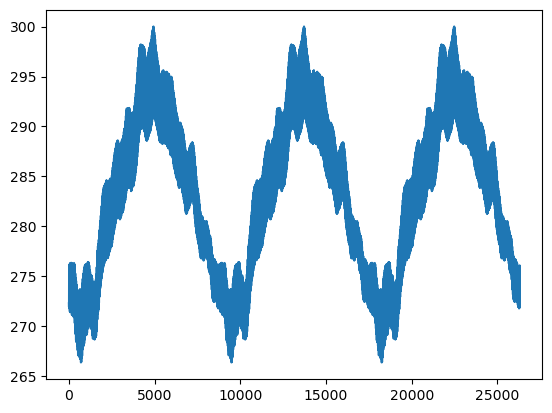

In [109]:
plt.plot(msc_e.sel(lat=40, lon=10, method='nearest').values.T.flatten())

In [103]:
msc_e.stack(time_=['time', 'hour']).reset_index('time_')

<xarray.DataArray 't2m' (lat: 101, lon: 101, time_: 26304)>
array([[[276.3001 , 276.27182, 276.22427, ..., 276.61542, 276.52554,
         276.59604],
        [276.3001 , 276.27182, 276.22427, ..., 276.61542, 276.52554,
         276.59604],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [271.1246 , 271.0442 , 270.99237, ..., 271.78296, 271.67456,
         271.55298],
        [271.0337 , 270.94025, 270.8777 , ..., 271.68066, 271.5876 ,
         271.462  ],
        [271.0068 , 270.91562, 270.85278, ..., 271.62213, 271.53662,
         271.4266 ]],

       [[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [271.804  , 271.79855, 271.73523, ..., 272.1856 , 271.98184,
         271.88486],
        [271.62048, 271.5712 , 271.5305 , ..., 271.9627 , 271.76477,
         271.65894],
        [271.51196, 271.45865, 271.40402, ..., 271.7868 , 271.57428,
         271.4837 ]],

       [[272.3159 , 272.13336, 272.04645, ..., 272.72427, 272.54654,
         272.40283],
        [271.71985, 271.5304 , 271.45477, ..., 272.14935, 271.96948,
         271.84848],
        [271.7503 , 271.6084 , 271.5411 , ..., 272.14914, 272.01236,
         271.87665],
        ...,
        [271.47513, 271.51376, 271.45245, ..., 271.7973 , 271.5607 ,
         271.42673],
        [271.2732 , 271.29272, 271.2526 , ..., 271.57303, 271.3423 ,
         271.19742],
        [271.17258, 271.10654, 271.0845 , ..., 271.4107 , 271.2016 ,
         271.0922 ]]], dtype=float32)
Coordinates:
  * lat        (lat) float32 55.0 54.9 54.8 54.7 54.6 ... 45.3 45.2 45.1 45.0
  * lon        (lon) float32 15.0 15.1 15.2 15.3 15.4 ... 24.7 24.8 24.9 25.0
    dayofyear  (time_) int64 1 1 1 1 1 1 1 1 ... 365 365 365 365 365 365 365 365
    time       (time_) datetime64[ns] 2004-01-01 2004-01-01 ... 2006-12-31
    hour       (time_) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
Dimensions without coordinates: time_
Attributes:
    long_name:  2 metre temperature
    units:      K

In [97]:
r = m.sel(dayofyear=ds.time.dt.dayofyear)
#r = r.stack(time=['dayofyear', 'hour']).reset_index('time')
r

KeyError: "no index found for coordinate 'dayofyear'"

In [89]:
r.sel(lat=40, lon=10, method='nearest').plot(figsize=(20, 3), lw=0.2)

KeyError: "no index found for coordinate 'lat'"

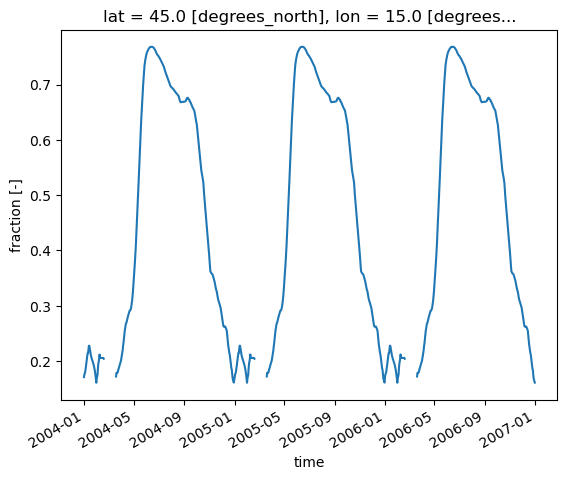

In [57]:
msc.sel(dayofyear=ds.time.dt.dayofyear).sel(lat=40, lon=10, method='nearest').plot()